In [1]:
import comet_ml
experiment = comet_ml.start()

from policy_bench.util import setup_cache, setup_logging
setup_logging()
setup_cache()
import logging
logger = logging.getLogger("policy_bench")
logger.setLevel('INFO')

import argon.random
import argon.transforms as agt
import argon.numpy as npx
import argon.ott.mpax as ott_mpax
import argon.ott as ott
import argon.train
import argon.tree
import argon.random

from argon.train import LossOutput
from argon.random import PRNGSequence
from argon.data import PyTreeData
from argon.diffusion.ddpm import DDPMSchedule

import argon.store.comet
import typing as tp

import jax
import seaborn as sns
sns.set_theme()

import argon.store
import sklearn.metrics
import chex
import pickle
import comet_ml

from sklearn.linear_model import LinearRegression

from argon.struct import struct, replace

from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pfrommerd/general/8b0837ce24d344ce92bf5eb0af4f4b74



In [2]:
def r2_scatter(ax, x, y, loc=None, log_xscale=False, **kwargs):
    model = LinearRegression()
    if log_xscale: x_reg = npx.log(x)
    else: x_reg = x
    model.fit(x_reg.reshape(-1, 1), y)
    y_pred = model.predict(x_reg.reshape(-1, 1))
    r2 = sklearn.metrics.r2_score(y, y_pred)

    h = ax.scatter(x, y, **kwargs)

    x0, x1 = ax.get_xaxis().get_view_interval()
    if log_xscale: 
        x0 = npx.maximum(x0, 1e-4)
        x0_reg, x1_reg = npx.log(npx.array([x0, x1]))
    else: 
        x0_reg, x1_reg = x0, x1

    y0, y1 = model.predict(((x0_reg,),))[0], model.predict(((x1_reg,),))[0]

    ax.add_line(plt.Line2D((x0, x1), (y0, y1), color="black", linestyle="--", linewidth=1))
    loc = (0.3, 0.3) if loc is None else loc
    ax.text(loc[0], loc[1], f"$r^2 = { r2 : 0.02}$", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    return h

In [23]:
from policy_bench.methods.diffusion_policy import DiffusionPolicy

RELAXATION_FACTOR = 3

@struct(frozen=True)
class DPData:
    schedule: DDPMSchedule
    denoiser: callable
    action_normalizer: tp.Any
    obs_normalizer: tp.Any
    train_obs: jax.Array
    obs: jax.Array
    ot: jax.Array
    var: jax.Array
    si: jax.Array

def dp_data():
    artifact = experiment.get_artifact("pusht-chi-diffusion_policy:15.0.0")
    checkpoint : DiffusionPolicy = argon.store.comet.from_artifact(artifact)
    dataset = checkpoint.data.create_dataset()
    env, splits = checkpoint.data.load(dataset, {"test", "train"})
    train_data = splits["train"].as_pytree()
    test_data = splits["test"].as_pytree()
    denoiser = checkpoint.create_denoiser()
    obs_normalizer = checkpoint.obs_normalizer
    act_normalizer = checkpoint.action_normalizer
    schedule = checkpoint.schedule

    test_obs = argon.tree.map(lambda x: x, train_data.observations)
    test_actions = argon.tree.map(lambda x: x, train_data.actions)
    indices = argon.random.permutation(argon.random.key(42), argon.tree.axis_size(test_obs))
    test_obs = argon.tree.map(lambda x: x[indices], test_obs)
    test_actions = argon.tree.map(lambda x: x[indices], test_actions)

    @agt.jit
    def measure_variance(schedule, denoiser, rng_key, obs):
        def measure_var(schedule, denoiser, rng_key, obs):
            def do_sample(schedule, denoiser, rng_key, eta=1.0):
                obs_normalized = obs_normalizer.normalize(obs)
                action = schedule.sample(rng_key, agt.partial(denoiser, obs_normalized), 
                                            act_normalizer.structure, eta=eta)
                action, _ = argon.tree.ravel_pytree(action)
                return action
            do_sample = agt.vmap(do_sample, in_axes=(None, None, 0, None))
            rng_key, s_rng = jax.random.split(rng_key, 2)
            ddpm_samples = do_sample(schedule, denoiser, jax.random.split(s_rng, 64), 0.0)
            ddpm_samples = ddpm_samples - npx.mean(ddpm_samples, axis=0)[None, :]
            ddpm_samples = npx.mean(npx.sum(npx.square(ddpm_samples), axis=-1))
            return ddpm_samples
        return agt.map(measure_var, batch_size=16, in_axes=(None, None, 0, 0))(
            schedule, denoiser, argon.random.split(rng_key, argon.tree.axis_size(obs)), obs
        )
    @agt.jit
    def measure_schedule_inconsistency(schedule, denoiser, batch_rng_key, obs_batch):
        def measure_si(schedule, denoiser, rng_key, obs):
            def t_si(schedule, denoiser, rng_key, t):
                def do_sample(schedule, denoiser, rng_key, eta=1.0):
                    obs_normalized = obs_normalizer.normalize(obs)
                    action = schedule.sample(rng_key, agt.partial(denoiser, obs_normalized), 
                                                act_normalizer.structure, eta=eta)
                    action_noised, _, _ = schedule.add_noise(rng_key, action, t)
                    return action, action_noised
                do_sample = agt.vmap(do_sample, in_axes=(None, None, 0, None))
                rng_key, s_rng = jax.random.split(rng_key, 2)
                ddpm_samples, noised_samples = do_sample(
                    schedule, denoiser,
                    jax.random.split(s_rng, 64), 0.0)

                def nw_output(x):
                    return schedule.output_from_denoised(x, t, schedule.compute_denoised(x, t, ddpm_samples))
                nw = jax.vmap(nw_output)(noised_samples)
                ddpm = jax.vmap(lambda x: denoiser(obs, None, x, t))(noised_samples)
                chex.assert_trees_all_equal_shapes_and_dtypes(nw, ddpm)
                nw = jax.vmap(lambda x: argon.tree.ravel_pytree(x)[0])(nw)
                ddpm = jax.vmap(lambda x: argon.tree.ravel_pytree(x)[0])(ddpm)
                return jax.vmap(lambda a, b: npx.linalg.norm(a - b))(nw, ddpm)
            sis = agt.vmap(t_si, in_axes=(None, None, 0, 0))(
                schedule, denoiser,
                argon.random.split(rng_key, schedule.num_steps // 4), 
                npx.arange(1, schedule.num_steps + 1, 4))
            # sis = t_si(rng_key, int(schedule.num_steps * 3/4))
            # sis = jax.vmap(t_si)(argon.random.split(rng_key, 1), npx.array(schedule.num_steps) // 2)
            return npx.mean(sis)
        return agt.map(measure_si, batch_size=16, in_axes=(None, None, 0, 0))(
            schedule, denoiser,
            argon.random.split(batch_rng_key, argon.tree.axis_size(obs_batch)), obs_batch
        )
    @agt.jit
    def measure_ddim_ddpm_ot(schedule, denoiser, batch_rng_key, obs_batch, noise=None):
        def measure_diff(schedule, denoiser, obs, rng_key):
            rng_key, n_rng_key = jax.random.split(rng_key)
            if noise is not None:
                obs_flat, uf = argon.tree.ravel_pytree(obs)
                obs_flat = obs_flat + noise * jax.random.normal(n_rng_key, obs_flat.shape)
                obs = uf(obs_flat)

            def do_sample(schedule, denoiser, rng_key, eta=1.0):
                obs_normalized = obs_normalizer.normalize(obs)
                action = schedule.sample(rng_key, agt.partial(denoiser, obs_normalized), 
                                        act_normalizer.structure, eta=eta)
                return action
            do_sample = agt.vmap(do_sample, in_axes=(None, None,0, None))

            ddim_rng, ddpm_rng = jax.random.split(rng_key)
            ddpm_samples = do_sample(schedule, denoiser, jax.random.split(ddpm_rng, 64), 0.0)
            ddim_samples = do_sample(schedule, denoiser, jax.random.split(ddim_rng, 64), 1.0)
            chex.assert_trees_all_equal_shapes_and_dtypes(ddpm_samples, ddim_samples)
            ddpm_flat = jax.vmap(lambda x: argon.tree.ravel_pytree(x)[0])(ddpm_samples)
            ddim_flat = jax.vmap(lambda x: argon.tree.ravel_pytree(x)[0])(ddim_samples)
            solver = ott_mpax.MpaxSolver(relaxation_factor=RELAXATION_FACTOR)
            C = npx.sum(npx.square(
                ddpm_flat[:, None, :] - ddim_flat[None, :, :]
            ), axis=-1)
            final_cost, _ = solver.solve(C)
            return final_cost
        results = agt.map(measure_diff, batch_size=16, in_axes=(None, None, 0, 0))(
            schedule, denoiser, obs_batch, 
            argon.random.split(batch_rng_key, argon.tree.axis_size(obs_batch))
        )
        return results
    test_ddpm_ot = measure_ddim_ddpm_ot(schedule, denoiser, argon.random.key(42), test_obs)
    test_var = measure_variance(
        schedule, denoiser, 
        argon.random.key(42), test_obs
    )
    test_si = measure_schedule_inconsistency(schedule, denoiser, argon.random.key(42), test_obs)
    return DPData(
        schedule, denoiser,
        act_normalizer,
        obs_normalizer,
        agt.vmap(obs_normalizer.normalize)(train_data.observations), 
        agt.vmap(obs_normalizer.normalize)(test_obs), 
        test_ddpm_ot, test_var, test_si
    )
dp_results = dp_data()

2025-03-15 19:42:19.762794: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce.1424 = f32[4096]{0} reduce(f32[4096,4096]{1,0} %broadcast.32946, f32[] %constant.19310), dimensions={0}, to_apply=%region_97.23932, metadata={op_name="jit(measure_ddim_ddpm_ot)/jit(main)/jit(transformed)/while/body/vmap(jit(solve))/jit(norm)/reduce_max" source_file="/home/daniel/Documents/code/argon/packages/algo/src/argon/solver/solver_log.py" source_line=174}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-03-15 19:42:22.657918: E external/xla/xla/service/slow_operation_alarm.cc:140] The opera

In [24]:
@agt.jit
def compute_transport_ex(schedule, denoiser, obs, rng_key):
    rng_key, n_rng_key = jax.random.split(rng_key)
    def do_sample(schedule, denoiser, rng_key, eta=1.0):
        action = schedule.sample(
            rng_key, agt.partial(denoiser, obs), 
            dp_results.action_normalizer.structure, eta=eta
        )
        action = dp_results.action_normalizer.unnormalize(action)
        return action
    do_sample = agt.vmap(do_sample, in_axes=(None, None,0, None))

    ddim_rng, ddpm_rng = jax.random.split(rng_key)
    ddpm_samples = do_sample(schedule, denoiser, jax.random.split(ddpm_rng, 32), 0.0)
    ddim_samples = do_sample(schedule, denoiser, jax.random.split(ddim_rng, 32), 1.0)
    chex.assert_trees_all_equal_shapes_and_dtypes(ddpm_samples, ddim_samples)
    ddpm_flat = jax.vmap(lambda x: argon.tree.ravel_pytree(x)[0])(ddpm_samples)
    ddim_flat = jax.vmap(lambda x: argon.tree.ravel_pytree(x)[0])(ddim_samples)
    solver = ott_mpax.MpaxSolver(relaxation_factor=RELAXATION_FACTOR)
    C = npx.sum(npx.square(
        ddpm_flat[:, None, :] - ddim_flat[None, :, :]
    ), axis=-1)
    final_cost, transport_plan = solver.solve(C)
    return ddpm_samples, ddim_samples, final_cost, transport_plan

ddpm_samples, ddim_samples, transport_cost, transport_plan = compute_transport_ex(dp_results.schedule, dp_results.denoiser,
    argon.tree.map(lambda x: x[0], dp_results.train_obs), argon.random.key(42)
)

In [33]:
def scale(obs):
    return obs 

def obs_density(obs):
    def dist(other):
        chex.assert_trees_all_equal_shapes_and_dtypes(obs, other)
        obs_normalized = obs
        other_normalized = other
        obs_normalized = scale(obs_normalized)
        other_normalized = scale(other_normalized)
        # obs_normalized = obs_normalized.agent_pos
        # other_normalized = other_normalized.agent_pos
        obs_flat, _ = argon.tree.ravel_pytree(obs_normalized)
        other_flat, _ = argon.tree.ravel_pytree(other_normalized)
        return npx.sum(npx.square(obs_flat - other_flat))
    dists = jax.vmap(dist)(argon.tree.map(lambda x: x[::3], dp_results.train_obs))
    log_probs = -50*dists / 2
    log_prob = jax.scipy.special.logsumexp(log_probs) - npx.log(dists.shape[0])
    return log_prob

test_densities = jax.vmap(obs_density)(dp_results.obs)
test_densities = test_densities - jax.scipy.special.logsumexp(test_densities)
test_densities = npx.exp(test_densities)

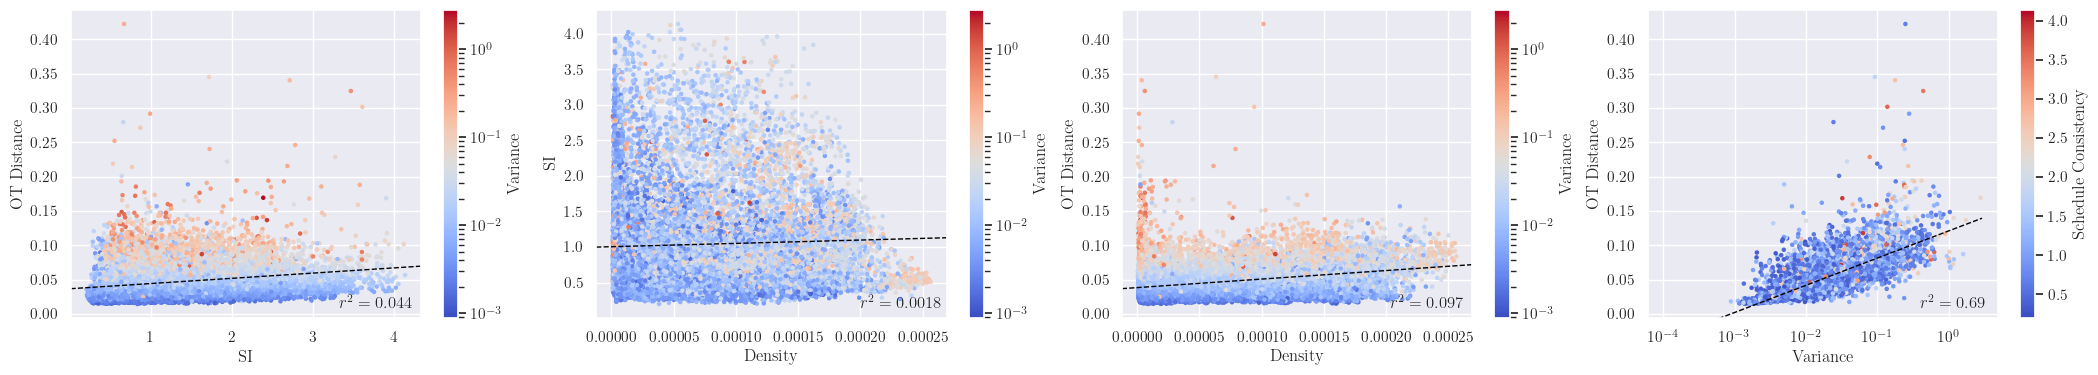

In [34]:
from matplotlib.cm import ScalarMappable
import matplotlib

log_var = True

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(26, 4))

# dp_mask = (dp_results.ot < 0.9)
dp_density = test_densities
dp_mask = npx.ones(dp_density.shape, dtype=bool)

scatter = r2_scatter(ax1, 
    dp_results.si[dp_mask],
    npx.sqrt(dp_results.ot.clip(0,None))[dp_mask],
    c=dp_results.var[dp_mask],
    s=5, loc=(0.87, 0.045),
    cmap="coolwarm",
    norm=matplotlib.colors.LogNorm() if log_var else None)
fig.colorbar(
    ScalarMappable(cmap=scatter.get_cmap(), norm=scatter.norm), ax=ax1,
    label="Variance"
)

scatter = r2_scatter(ax2, 
    dp_density[dp_mask],
    dp_results.si[dp_mask],
    c=dp_results.var[dp_mask],
    s=5, loc=(0.87, 0.045),
    cmap="coolwarm",
    norm=matplotlib.colors.LogNorm() if log_var else None)
fig.colorbar(
    ScalarMappable(cmap=scatter.get_cmap(), norm=scatter.norm), ax=ax2,
    label="Variance"
)

scatter = r2_scatter(ax3, 
    dp_density[dp_mask],
    npx.sqrt(dp_results.ot.clip(0,None))[dp_mask],
    c=dp_results.var[dp_mask],
    s=5, loc=(0.87, 0.045),
    cmap="coolwarm",
    norm=matplotlib.colors.LogNorm() if log_var else None)
fig.colorbar(
    ScalarMappable(cmap=scatter.get_cmap(), norm=scatter.norm), ax=ax3,
    label="Variance"
)

scatter = r2_scatter(ax4, 
    dp_results.var[dp_mask],
    npx.sqrt(dp_results.ot.clip(0,None))[dp_mask],
    c=dp_results.si[dp_mask],
    s=5, loc=(0.87, 0.045),
    log_xscale=True,
    cmap="coolwarm")
ax4.set_xscale("log")
    #norm=matplotlib.colors.LogNorm() if log_var else None)
fig.colorbar(
    ScalarMappable(cmap=scatter.get_cmap(), norm=scatter.norm), ax=ax4,
    label="Schedule Consistency"
)

ax4.set_xlabel("Variance")
ax4.set_ylabel("OT Distance")
ax1.set_xlabel("SI")
ax1.set_ylabel("OT Distance")
ax2.set_xlabel("Density")
ax2.set_ylabel("SI")
ax3.set_xlabel("Density")
ax3.set_ylabel("OT Distance")


fig.show()